# Natural Computing

## Exercises on Evolutionary Computation

In [3]:
import tsplib95 # pip install tsplib95
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from operator import itemgetter
import time
from tqdm import tqdm
%matplotlib inline

## Exercise 6

#### Simple EA for TSP:
- Random initialization of the population
- Binary tournament selection (results in mating pool)
- Generational gap replacement strategy (10% elitism: 10% of worst offspring replaced by best current parents)
- Fixed size population

### Utility functions

In [4]:
# List of tuples representing edges for plotting
def get_edge_list(tour):
    edge_list = []
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        edge_list.append( (a, b) )
    # close tour
    edge_list.append( (tour[-1], tour[0]) )
    return edge_list

# Plot tour including performance
def plot_tour(tour, distance, problem):
    edge_list = get_edge_list(tour)
    nx.draw_networkx(problem.get_graph(), 
                     pos=problem.node_coords, 
                     edgelist=edge_list, 
                     node_size=50,
                     with_labels=False
                    )
    plt.title(f"{problem.name} ({distance})")
    plt.show()

In [5]:
# Get best and worst tour, and average tour distance in population
def population_stats(population):
    best = min(population, key=itemgetter(1))
    worst = max(population, key=itemgetter(1))
    avg = np.mean([tour[1] for tour in population])
    return best, worst, avg

# Summary of a population
def track_progress(problem, population, gen_id):
    # get population statistics
    best, worst, avg = population_stats(population)
    # print statistics
    print('='*5, f"Generation {gen_id}", '='*5)
    print("Best: ", best[1])
    print("Worst: ", worst[1])
    print("Average: ", avg)
    # plot the best tour
    plot_tour(best[0], best[1], problem)

In [6]:
def plot_history(generations, solution_dist):
    best_scores = [best[1] for best, _, _ in generations]
    worst_scores = [worst[1] for _, worst, _ in generations]
    avg_scores = [avg for _, _, avg in generations]
    
    nr_of_generations = len(generations)
    x_range = range(nr_of_generations)
    plt.figure(figsize=(12, 8))
    plt.plot(x_range, best_scores, label = "best distance")
    plt.plot(x_range, worst_scores, label = "worst distance")
    plt.plot(x_range, avg_scores, label = "avg distance")
    plt.plot(x_range, [solution_dist]*nr_of_generations, label = "optimal distance")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.title("Evolution over generations", size=14)
    plt.legend()
    plt.show()

### Evolutionary Algorithm

In [7]:
def init_population(problem, size):
    nodes = list(problem.get_nodes())
    population = [np.random.permutation(nodes) for _ in range(size)]
    population = [(list(tour), total_distance(tour, problem)) for tour in population] # tuple(tour, distance)
    return population

In [8]:
# Fitness function
def total_distance(tour, problem):
    total_dist = 0
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        dist = problem.wfunc(a, b)
        total_dist += dist
    # close tour
    total_dist += problem.wfunc(tour[-1], tour[0])
    return total_dist

In [9]:
# Binary tournament selection
def tournament(population):
    participants = random.sample(population, 2)
    winner = min(participants, key=itemgetter(1))
    return winner

In [10]:
def ordered_crossover(parent1, parent2):
    # choose two cut points
    length = len(parent1)
    pos1, pos2 = random.sample(range(length), 2)
    start_pos = min(pos1, pos2)
    end_pos = max(pos1, pos2)
    
    # slice between cut points
    child1 = parent1[start_pos:end_pos+1]
    child2 = parent2[start_pos:end_pos+1]
    
    # fill missing cities in order they appear in other parent
    missing_cities1 = [city for city in parent2 if city not in child1]
    missing_cities2 = [city for city in parent1 if city not in child2]
    
    # append missing cities starting from 2nd cut point
    child1 += missing_cities1
    child2 += missing_cities2
    return child1, child2

def mutation(tour):
    # shallow copy of original
    mutated_tour = tour[:]
    
    # choose two positions
    length = len(tour)
    pos1, pos2 = random.sample(range(length), 2)
    
    # reverse sequence mutation
    mutated_tour[pos1], mutated_tour[pos2] = mutated_tour[pos2], mutated_tour[pos1]
    return mutated_tour

In [11]:
def next_generation(problem, mating_pool, size, p_c, p_m):
    new_population = []
    while len(new_population) < size:
        # select two parents from mating pool
        parent1, parent2 = random.sample(mating_pool, 2) 
        parent1, parent2 = parent1[0], parent2[0] # get tour            
        # initalize offspring to be equal to parent
        child1, child2 = parent1[:], parent2[:]

        # ordered crossover
        test_p_c = np.random.uniform()
        if test_p_c < p_c:
            child1, child2 = ordered_crossover(parent1, parent2)
                
        # mutation
        test_p_m = np.random.uniform()
        if test_p_m < p_m:
            child1, child2 = mutation(child1), mutation(child2)
            
        # add offspring to new population
        dist1 = total_distance(child1, problem)
        dist2 = total_distance(child2, problem)
        new_population += [ (child1, dist1), (child2, dist2) ]
    return new_population

In [12]:
def exert_elitism(population, new_population, size, elitism):
    # compute elite size
    elite = int(size * elitism)
    
    # drop worst tours from new population
    distances_new = [distance for _, distance in new_population]
    idx_drop = list(np.argpartition(distances_new, -elite))[-elite:]
    elite_population = [tour for i, tour in enumerate(new_population) if i not in idx_drop]
        
    # add elite (best tours) from current population to new population
    distances_old = [distance for _, distance in population]
    idx_elite = list(np.argpartition(distances_old, elite))[:elite]  
    elitists = [tour for i, tour in enumerate(population) if i in idx_elite]
    elite_population += elitists
    
    return elite_population

In [13]:
def EA_TSP(problem, size=100, nr_of_generations=200, p_c=0.9, p_m=0.2, elitism=0.1, plot_every=-1):
    # history
    generations = []
    
    # initialize population
    population = init_population(problem, size)
    if plot_every > 0:
        track_progress(problem, population, 1)
    
    for t in range(nr_of_generations):
        # tournament selection for mating pool
        mating_pool = [tournament(population) for _ in range(size)]
        
        # generate offspring for generational replacement
        new_population = next_generation(problem, mating_pool, size, p_c, p_m) 
        
        # elitism
        new_population = exert_elitism(population, new_population, size, elitism)    
        population = new_population
        
        generations.append(population_stats(population))
        
        # plot every so often to monitor progress
        if t % plot_every == plot_every-1:
            track_progress(problem, new_population, t+1)
        
    return generations

### Memetic Algorithm

Re-uses code from the Evolutionary Algorithm with some modifications to incorporate local search.

In [95]:
def local_search(problem, candidate, depth=10):
    """
    Local search with edge exchange.
    Does not consider whole neighbor set,
    but only tries `depth` edge exchanges.
    """
    tour, dist = candidate
    length = len(tour)
    best_tour = tour
    best_dist = dist
    for _ in range(depth):
        # sample two positions
        pos1, pos2 = random.sample(range(length), 2) # indices
        while abs(pos1 - pos2) == 1: # sample again if positions are neighbors
            pos1, pos2 = random.sample(range(len(tour)), 2)
            
        # account for end of list
        pos1_next, pos2_next = pos1 + 1, pos2 + 1
        if pos1 == length-1:
            pos1_next = 0
        if pos2 == length-1:
            pos2_next = 0
        
        # edge exchange
        neighbor = tour[:] # shallow copy
        neighbor[pos1_next], neighbor[pos2] = neighbor[pos2], neighbor[pos1_next]
        neighbor_dist = total_distance(neighbor, problem)
        
        # store best neighbor tour and distance
        if neighbor_dist < best_dist:
            best_tour = neighbor
            best_dist = neighbor_dist
            
    return best_tour, best_dist

In [96]:
def next_generation_memetic(problem, mating_pool, size, p_c, p_m):
    new_population = []
    while len(new_population) < size:
        # select two parents from mating pool
        parent1, parent2 = random.sample(mating_pool, 2) 
        parent1, parent2 = parent1[0], parent2[0] # get tour            
        # initalize offspring to be equal to parent
        child1, child2 = parent1[:], parent2[:]

        # ordered crossover
        test_p_c = np.random.uniform()
        if test_p_c < p_c:
            child1, child2 = ordered_crossover(parent1, parent2)
                
        # mutation
        test_p_m = np.random.uniform()
        if test_p_m < p_m:
            child1, child2 = mutation(child1), mutation(child2)
            
        dist1 = total_distance(child1, problem)
        dist2 = total_distance(child2, problem)
        child1 = local_search(problem, (child1,dist1)) 
        child2 = local_search(problem, (child2,dist2)) 
            
        # add offspring to new population
        new_population += [ child1, child2 ]
    return new_population

In [97]:
def memetic_TSP(problem, size=100, nr_of_generations=200, p_c=0.9, p_m=0.2, elitism=0.1, plot_every=-1):
    # history
    generations = []
    
    # initialize population
    population = init_population(problem, size)
    # local search
    population = [local_search(problem, candidate) for candidate in population]
    if plot_every > 0:
        track_progress(problem, population, 1)
    
    for t in range(nr_of_generations):
        # tournament selection for mating pool
        mating_pool = [tournament(population) for _ in range(size)]
        
        # generate offspring for generational replacement with local search
        new_population = next_generation_memetic(problem, mating_pool, size, p_c, p_m) 
        
        # elitism
        new_population = exert_elitism(population, new_population, size, elitism)    
        population = new_population
        
        generations.append(population_stats(population))
        
        # plot every so often to monitor progress
        if t % plot_every == plot_every-1:
            track_progress(problem, new_population, t+1)
        
    return generations

### Main procedure

In [84]:
def load_TSP(problem_path, solution_path):
    problem = tsplib95.load_problem(problem_path)
    print("--- TSP problem information ---")
    print("Name: ", problem.name)
    print("Comment: ", problem.comment)
    print("Dimension: ", problem.dimension)
    print("Edge weight type: ", problem.edge_weight_type)
    
    solution = tsplib95.load_solution(solution_path)
    solution_dist = problem.trace_tours(solution)[0]
    print("Optimal solution: ", solution_dist)
    plot_tour(solution.tours[0], solution_dist, problem)
    
    return problem, solution

In [85]:
def main(problem, solution, n_gen):
    plot_every = n_gen / 5

    start = time.time()
    generations = EA_TSP(problem, 
                         nr_of_generations=n_gen, 
                         plot_every=plot_every)
    end = time.time()
    print("Elapsed time: {0:0.2f}s".format(end-start))
    
    solution_dist = problem.trace_tours(solution)[0]
    plot_history(generations, solution_dist)

In [86]:
def multiple_runs(problem, n_gen, n_runs=10):   
    best_in_runs = []
    for i in tqdm( range(n_runs) ):
        generations = EA_TSP(problem, 
                             nr_of_generations=n_gen)
        best = min( [best[1] for best, _, _ in generations] )
        best_in_runs.append(best)
    return best_in_runs

In [92]:
def main_memetic(problem, solution, n_gen):
    plot_every = n_gen / 5

    start = time.time()
    generations = memetic_TSP(problem, 
                         nr_of_generations=n_gen, 
                         plot_every=plot_every)
    end = time.time()
    print("Elapsed time: {0:0.2f}s".format(end-start))
    
    solution_dist = problem.trace_tours(solution)[0]
    plot_history(generations, solution_dist)

In [102]:
def multiple_runs_memetic(problem, n_gen, n_runs=10):   
    best_in_runs = []
    for i in tqdm( range(n_runs) ):
        generations = memetic_TSP(problem, 
                             nr_of_generations=n_gen)
        best = min( [best[1] for best, _, _ in generations] )
        best_in_runs.append(best)
    return best_in_runs

### TSP: berlin52

--- TSP problem information ---
Name:  berlin52
Comment:  52 locations in Berlin (Groetschel)
Dimension:  52
Edge weight type:  EUC_2D
Optimal solution:  7542


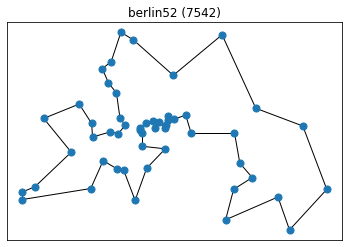

In [87]:
berlin52_problem, berlin52_solution = load_TSP('data/berlin52.tsp', 'data/berlin52.opt.tour')

**Evolutionary Algorithm**

===== Generation 1 =====
Best:  25760
Worst:  32570
Average:  29519.89


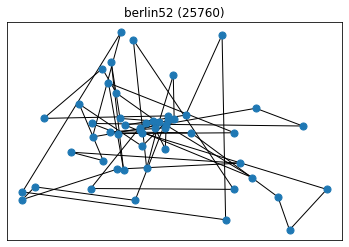

===== Generation 200 =====
Best:  9909
Worst:  13157
Average:  11292.15


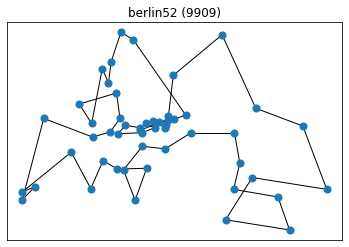

===== Generation 400 =====
Best:  8618
Worst:  11698
Average:  9885.48


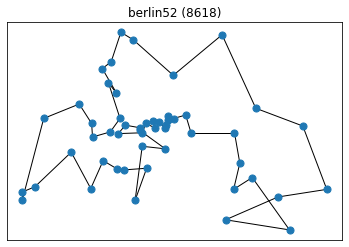

===== Generation 600 =====
Best:  7829
Worst:  12105
Average:  9679.43


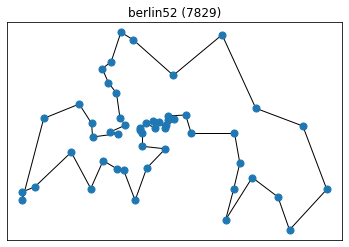

===== Generation 800 =====
Best:  7645
Worst:  11343
Average:  9290.41


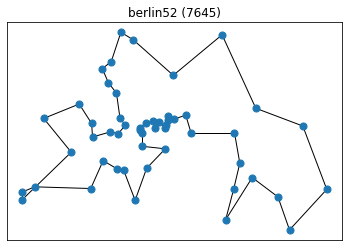

===== Generation 1000 =====
Best:  7641
Worst:  10721
Average:  8885.57


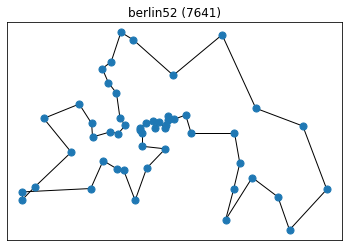

Elapsed time: 17.20s


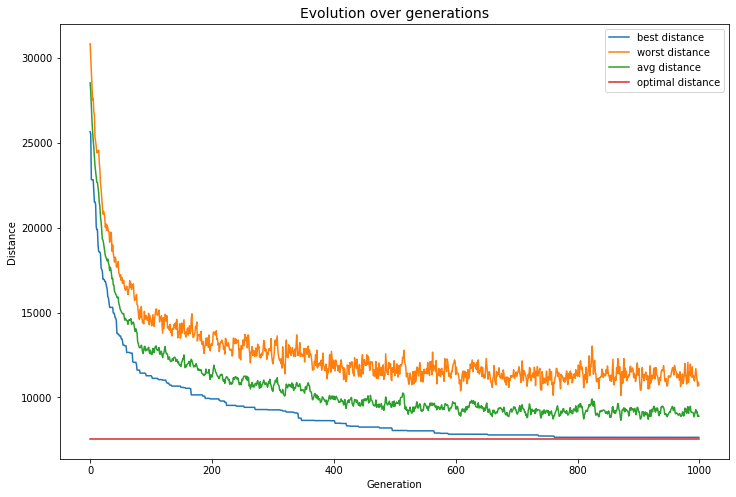

In [20]:
main(berlin52_problem, berlin52_solution, 1000)

In [23]:
# Run EA multiple times to account for variance between runs
berlin52_best = multiple_runs(berlin52_problem, 1000)

100%|████████████████████████████████████████████████████| 10/10 [02:44<00:00, 16.46s/it]


In [27]:
print("Best over runs:", berlin52_best)
print("Mean:", np.mean(berlin52_best))
print("Standard deviation:", np.std(berlin52_best))

Best over runs: [8140, 8403, 8580, 8308, 8270, 8697, 8573, 8197, 8258, 8575]
Mean: 8400.1
Standard deviation: 183.1690203063826


**Memetic**

Fewer generations are used because of run time and it seems that the memetic variant stagnates earlier anyway.

===== Generation 1 =====
Best:  25462
Worst:  32676
Average:  29184.65


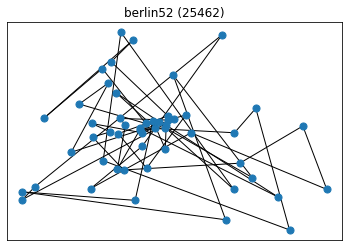

===== Generation 100 =====
Best:  10819
Worst:  15375
Average:  12889.26


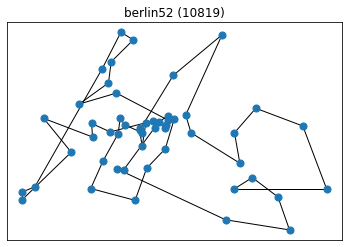

===== Generation 200 =====
Best:  9210
Worst:  12074
Average:  10336.12


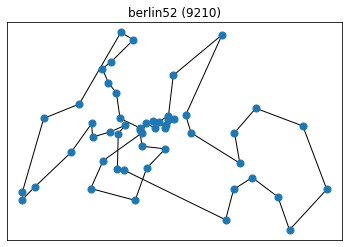

===== Generation 300 =====
Best:  8714
Worst:  12361
Average:  10037.18


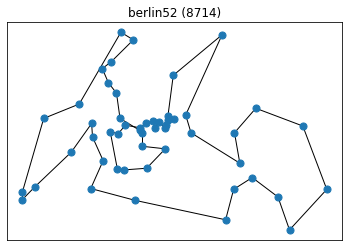

===== Generation 400 =====
Best:  8627
Worst:  12048
Average:  10277.47


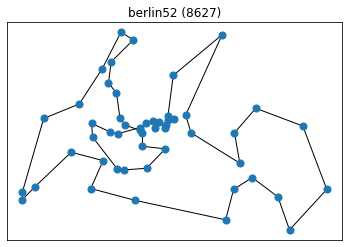

===== Generation 500 =====
Best:  8627
Worst:  12192
Average:  9990.01


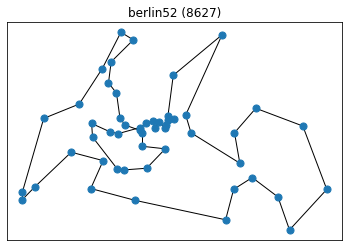

Elapsed time: 77.33s


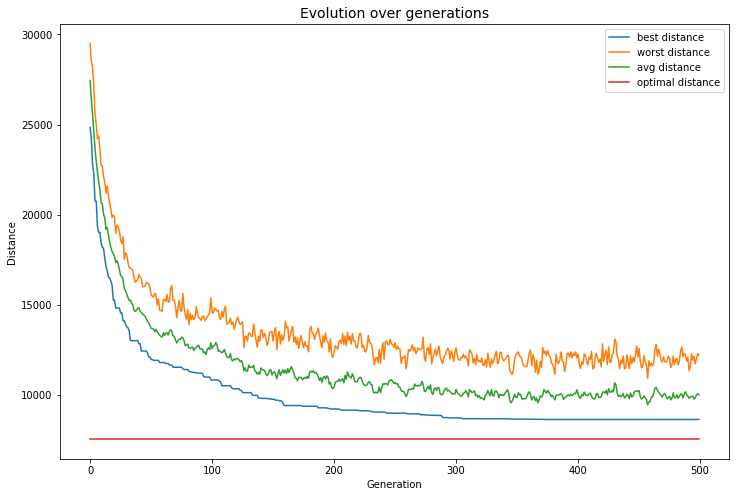

In [99]:
main_memetic(berlin52_problem, berlin52_solution, 500)

In [103]:
# Run Memetic Algorithm multiple times to account for variance between runs
# Note: this can take a while (~12 minutes)
berlin52_best_memetic = multiple_runs_memetic(berlin52_problem, 500)

100%|████████████████████████████████████████████████████| 10/10 [12:39<00:00, 75.96s/it]


In [104]:
print("Best over runs:", berlin52_best_memetic)
print("Mean:", np.mean(berlin52_best_memetic))
print("Standard deviation:", np.std(berlin52_best_memetic))

Best over runs: [8645, 8275, 8164, 8298, 8217, 7883, 8065, 8222, 8250, 8090]
Mean: 8210.9
Standard deviation: 186.3998122316651


### TSP: st70

--- TSP problem information ---
Name:  st70
Comment:  70-city problem (Smith/Thompson)
Dimension:  70
Edge weight type:  EUC_2D
Optimal solution:  675


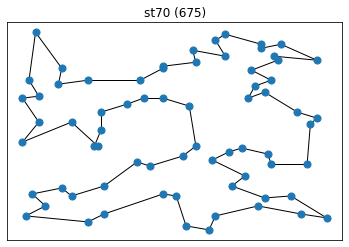

In [100]:
st70_problem, st70_solution = load_TSP('data/st70.tsp', 'data/st70.opt.tour')

**Evolutionary Algorithm**

===== Generation 1 =====
Best:  3239
Worst:  4102
Average:  3712.5


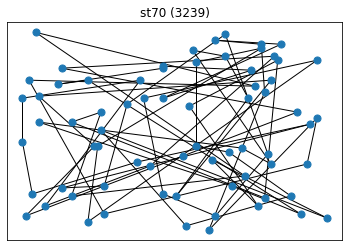

===== Generation 200 =====
Best:  1170
Worst:  1497
Average:  1302.94


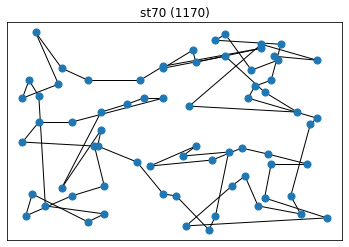

===== Generation 400 =====
Best:  946
Worst:  1269
Average:  1073.13


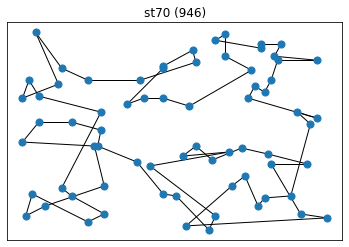

===== Generation 600 =====
Best:  862
Worst:  1264
Average:  1044.8


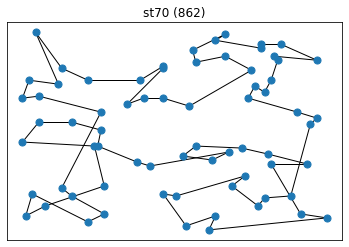

===== Generation 800 =====
Best:  831
Worst:  1198
Average:  992.01


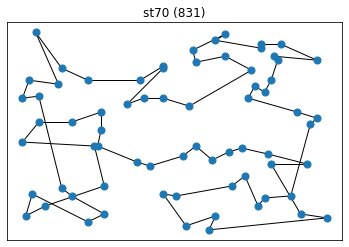

===== Generation 1000 =====
Best:  811
Worst:  1167
Average:  954.63


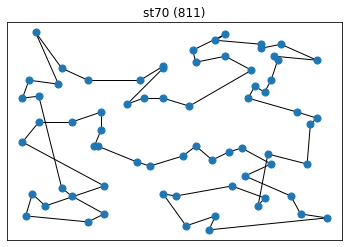

Elapsed time: 21.81s


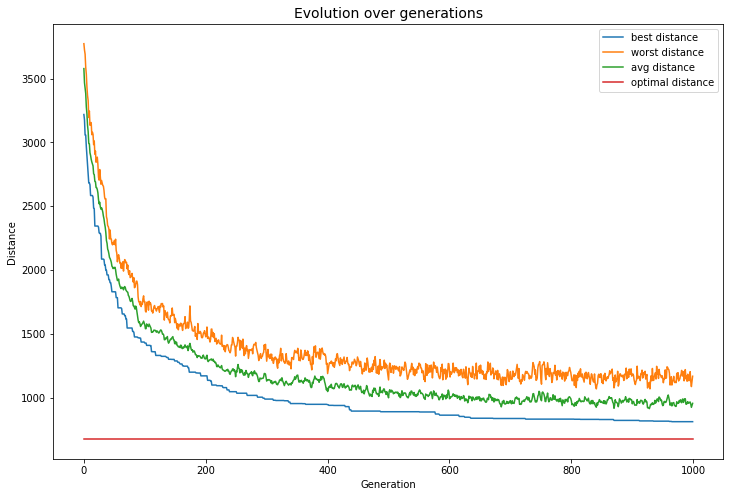

In [15]:
main(st70_problem, st70_solution, 1000)

In [19]:
# Run EA multiple times to account for variance between runs
st70_best = multiple_runs(st70_problem, 1000)

100%|████████████████████████████████████████████████████| 10/10 [03:29<00:00, 20.91s/it]


In [ ]:
print("Best over runs:", st70_best)
print("Mean:", np.mean(st70_best))
print("Standard deviation:", np.std(st70_best))

**Memetic**

Fewer generations are used because of run time and it seems that the memetic variant stagnates earlier anyway.

===== Generation 1 =====
Best:  3055
Worst:  3922
Average:  3573.64


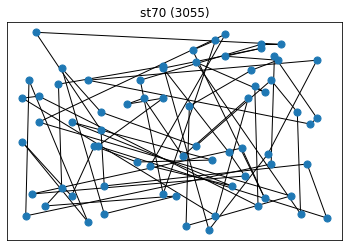

===== Generation 100 =====
Best:  1412
Worst:  1847
Average:  1636.19


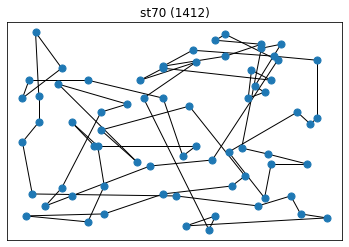

===== Generation 200 =====
Best:  1142
Worst:  1476
Average:  1307.72


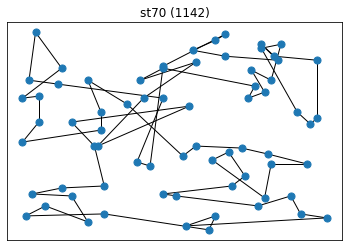

===== Generation 300 =====
Best:  930
Worst:  1237
Average:  1078.58


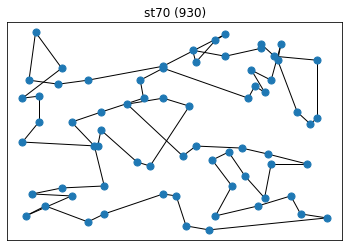

===== Generation 400 =====
Best:  817
Worst:  1143
Average:  958.56


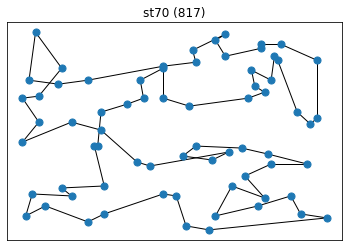

===== Generation 500 =====
Best:  758
Worst:  1087
Average:  903.54


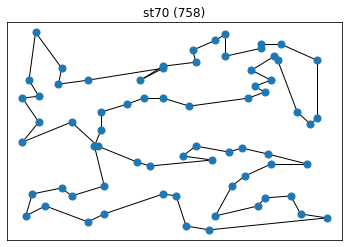

Elapsed time: 104.62s


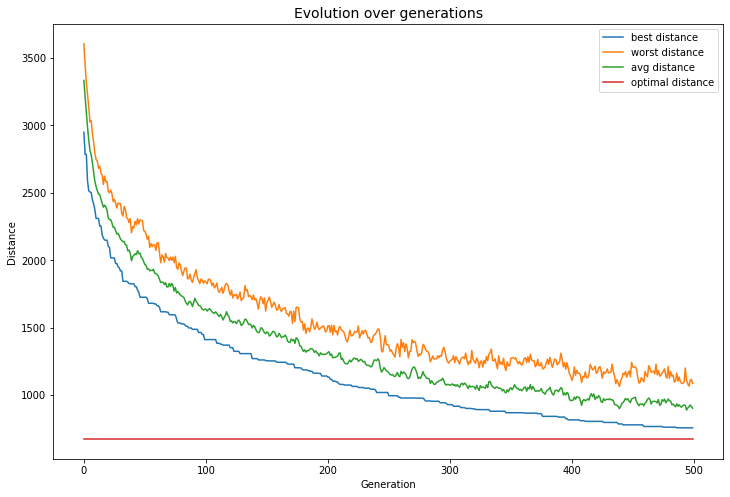

In [101]:
main_memetic(st70_problem, st70_solution, 500)

In [ ]:
# Run Memetic Algorithm multiple times to account for variance between runs
# Note: this can take a while (~15 minutes)
st70_best_memetic = multiple_runs_memetic(st70_problem, 500)

In [ ]:
print("Best over runs:", st70_best_memetic)
print("Mean:", np.mean(st70_best_memetic))
print("Standard deviation:", np.std(st70_best_memetic))